## Model evaluation

For model performance assessment we want to obtain the distribution of the model accuracy over N independent runs of the training procedure.

* [The experiment details](#The-experiment-details)
* [Results](#Results)


In [1]:
import os
import sys
import glob
import dill
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, os.path.join("..", ".."))
from batchflow import Dataset, B, V, C, Pipeline
from batchflow.models.tf import UNet
from batchflow.research import Research, Results

from src import ShapesBatch, show_samples, show_histogram

%env CUDA_VISIBLE_DEVICES='6,7'

env: CUDA_VISIBLE_DEVICES='6,7'


## The experiment details

Dataset loading

In [2]:
imset = Dataset(1000, ShapesBatch)

Define model config

In [3]:
model_config={'inputs/images/shape': B('image_shape'),
              'inputs/masks/shape': B('image_shape'),
              'initial_block/inputs': 'images',
              'initial_block/filters': 12, 
              'body/encoder/num_stages': 3,
              'body/encoder/blocks/filters': [24, 48, 96], 
              'body/decoder/blocks/filters': [96, 48, 24],
              'head/filters': 12,
              'loss': 'bce',
              'optimizer': 'Adam',
              'output': 'sigmoid',
             }

Define training and test pipeline

In [4]:
batch_size = 20

train_template = (Pipeline()
                  .init_model('dynamic', UNet, 'unet', config=model_config)
                  .sample_images(128, max_r=24)
                  .train_model('unet', fetches='loss', images=B('images'), masks=B('masks'))
                  .run_later(batch_size=batch_size, n_epochs=None))

test_template = (Pipeline()
                 .import_model('unet', C('import_from'))
                 .init_variable('predictions')
                 .init_variable('metrics', init_on_each_run=None)
                 .sample_images(128, max_r=24)
                 .predict_model('unet', fetches='sigmoid', images=B('images'),
                                save_to=V('predictions'))
                 .gather_metrics('segmentation',
                                 targets=B('masks'),
                                 predictions=V('predictions'),
                                 fmt='proba',
                                 save_to=V('metrics', mode='u'))
                 .run_later(batch_size, n_epochs=1))

Create a research object:

In [5]:
research = (Research()
            .add_pipeline(train_template << imset, name='train')
            .add_pipeline(test_template << imset, variables='metrics', execute='last',
                          name='test', run=True, import_from='train')
            .get_metrics(pipeline='test', metrics_var='metrics', metrics_name='iou',
                         returns='iou', execute='last')
           )

Run 20 independent training and test procedures 

In [6]:
research.run(n_reps=20, n_iters=200, name='model_estimation_research', bar=True, workers=2, gpu=[6,7])

Research model_estimation_research is starting...


  0%|          | 0/4000 [00:00<?, ?it/s]

Distributor has 20 jobs with 200 iterations. Totally: 4000


100%|██████████| 4000/4000 [06:30<00:00, 10.24it/s]


In [7]:
df = research.load_results(names='test_metrics')

## Results

Histogram and a median value of the test metrics

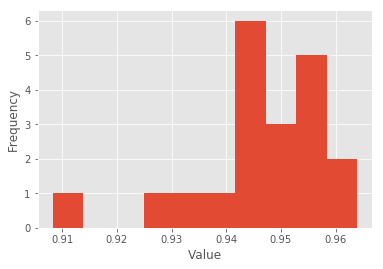

The average (median) value is  0.947


In [8]:
show_histogram(df.iou.values)
print('The average (median) value is  %.3f' % np.median(df.iou.values))